<a href="https://colab.research.google.com/github/VinishUchiha/Fine-Tuning-BERT/blob/master/Sentence_Classification/fine_tuning_bert_for_sentence_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')

Tesla K80


In [2]:
!pip install transformers

     |████████████████████████████████| 675kB 6.3MB/s 
     |████████████████████████████████| 3.8MB 35.1MB/s 
     |████████████████████████████████| 890kB 42.0MB/s 
     |████████████████████████████████| 1.1MB 34.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=68a6cea7e1211c03d79e1defd5beee501d7bfbb4e1006165aae818567f957031
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
!wget https://nyu-mll.github.io/CoLA/cola_public_1.1.zip

--2020-06-11 13:42:58--  https://nyu-mll.github.io/CoLA/cola_public_1.1.zip
Resolving nyu-mll.github.io (nyu-mll.github.io)... 185.199.109.153, 185.199.110.153, 185.199.108.153, ...
Connecting to nyu-mll.github.io (nyu-mll.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255330 (249K) [application/zip]
Saving to: ‘cola_public_1.1.zip’

cola_public_1.1.zip 100%[===================>] 249.35K  --.-KB/s    in 0.02s   

2020-06-11 13:42:59 (10.6 MB/s) - ‘cola_public_1.1.zip’ saved [255330/255330]



In [4]:
!unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [5]:
import pandas as pd

df = pd.read_csv('/content/cola_public/raw/in_domain_train.tsv',delimiter='\t',header = None,names=['sentence_source','label','label_notes','sentence'])

df.sample(10)

,sentence_source,label,label_notes,sentence
5735,c_13,1,NaN,He turned off the light.
1662,r-67,0,*,"Fluffy is sick, which that no one here realize..."
4574,ks08,0,*,Sam may have been being interrogating by the FBI.
3918,ks08,0,*,The problem disappeared the accusation.
529,bc01,1,NaN,The tree dropped its fruit to the ground.
7172,sks13,1,NaN,"They play unusual music, and I listen to unusu..."
5835,c_13,1,NaN,I want Mary to sign my yearbook.
152,cj99,0,?*,I can well imagine with a hatchet Mary destroy...
1612,r-67,1,NaN,"Mickey and Roger have signed, and Whitey will ..."
163,cj99,1,NaN,Mary gets depressed and she listens to the Gra...


In [6]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
148,"It is important for the more you eat, the more...",0
1862,I noticed car in the driveway last night your ...,0
8311,Gilgamesh might loved Ishtar,0
2334,The jeweller decorated the name on the ring.,0
5044,I believe that the problem is not easy to be o...,0


In [7]:
df.loc[df.label == 1].sample(5)[['sentence','label']]

,sentence,label
4,Day by day the facts are getting murkier.,1
4742,I ask you if this is what you want.,1
101,"When you eat more, you want correspondingly less.",1
8023,Kane ate dirt.,1
7767,It appears that Poseidon owns a dragon,1


In [0]:
sentences = df.sentence.values
labels = df.label.values

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [10]:
print('Original: ',sentences[0])
print('Tokenized: ',tokenizer.tokenize(sentences[0]))
print('Token ids: ',tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token ids:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [11]:
#measuring the maximum sentence length
max_len = 0

for sent in sentences:
  input_ids = tokenizer.encode(sent,add_special_tokens=True)
  max_len = max(max_len,len(input_ids))

print('max_seq_len: ',max_len)

max_seq_len:  47


In [12]:
#Tokenize all the sentence and map the tokens to their word ids
input_ids = []
attention_masks = []

for sent in sentences:
  encoded_dict = tokenizer.encode_plus(
      sent,
      add_special_tokens=True,
      max_length=64,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt'
  )
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

#convert the lists into tensors
input_ids = torch.cat(input_ids,dim=0)
attention_masks = torch.cat(attention_masks,dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [13]:
from torch.utils.data import TensorDataset,random_split

# Combine the training inputs into a TensorDataset
dataset = TensorDataset(input_ids,attention_masks,labels)

#split 90% for training 10% for validation
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('Training example size: ',train_size)
print('Validation Size: ',val_size)

Training example size:  7695
Validation Size:  856


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)

val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=batch_size)

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

#load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
#optimizer
optimizer = AdamW(model.parameters(),lr=2e-5,eps=1e-8)

In [0]:
from transformers import get_linear_schedule_with_warmup

#No. of epochs,BERT authors recommend 2-4
epochs = 4

total_steps = len(train_dataloader) * epochs

#learning rate sheduler
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,
                                            num_training_steps=total_steps)

In [0]:
#helper function for calculating accuracy
import numpy as np

def flat_accuracy(preds,labels):
  pred_flat = np.argmax(preds,axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
#Helper function formating ETA
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [21]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch in range(epochs):

  print('Epoch: ',epoch+1)
  t0 = time.time()

  #Reset the total loss from this epoch
  total_train_loss = 0

  model.train()

  for step, batch in enumerate(train_dataloader):

    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels
    b_input_ids = batch[0].to(device)
    b_input_masks = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    loss, logits = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask = b_input_masks,
                         labels = b_labels)
    
    total_train_loss += loss.item()

    loss.backward()
    #gradient clipping prevents exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
    #update the parameters
    optimizer.step()
    # Update the learning rate.
    scheduler.step()
  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_dataloader)
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epoch took: {:}".format(training_time))

  #Validation
  t0 = time.time()
  model.eval()

  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  for batch in val_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
      (loss, logits) = model(b_input_ids, 
                                  token_type_ids=None, 
                                  attention_mask=b_input_mask,
                                  labels=b_labels)
    # Accumulate the validation loss.
    total_eval_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, label_ids)

  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(val_dataloader)
  
  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)
  
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
          'Valid. Accur.': avg_val_accuracy,
          'Training Time': training_time,
          'Validation Time': validation_time
      }
  )
                               
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Epoch:  1

  Average training loss: 0.43
  Training epoch took: 0:02:29
  Accuracy: 0.82
  Validation Loss: 0.39
  Validation took: 0:00:05
Epoch:  2

  Average training loss: 0.27
  Training epoch took: 0:02:29
  Accuracy: 0.83
  Validation Loss: 0.44
  Validation took: 0:00:05
Epoch:  3

  Average training loss: 0.17
  Training epoch took: 0:02:29
  Accuracy: 0.84
  Validation Loss: 0.51
  Validation took: 0:00:06
Epoch:  4

  Average training loss: 0.11
  Training epoch took: 0:02:29
  Accuracy: 0.84
  Validation Loss: 0.59
  Validation took: 0:00:05
Total training took 0:10:19 (h:mm:ss)


In [22]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.43,0.39,0.82,0:02:29,0:00:05
2,0.27,0.44,0.83,0:02:29,0:00:05
3,0.17,0.51,0.84,0:02:29,0:00:06
4,0.11,0.59,0.84,0:02:29,0:00:05


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


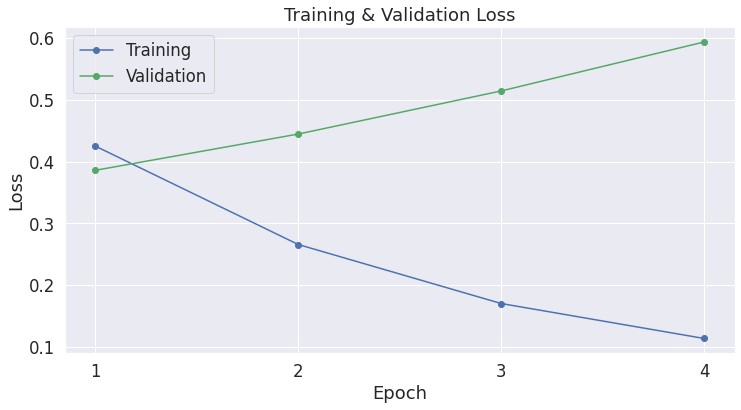

In [23]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()